In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
plt.rcParams["figure.figsize"] = 10, 8
plt.rcParams["font.size"     ] = 14

In [2]:

import numpy as np
import pandas as pd
from collections import namedtuple
import os
import glob
from pathlib import Path
 
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision import datasets
from torch.utils.data.sampler import SubsetRandomSampler
from torchsummary import summary
from torchvision.transforms import v2

from pymono.cnns import x_cnn_evaluation, x_single_run, x_train_cnn
from pymono.cnns import Conv2dPars,  MaxPool2dPars,  LinealLayerPars
from pymono.cnns import build_conv_layer, build_conv_layers, build_linear_layers
from pymono.cnns import xCNN, xResNet10, xResNet8, ResBlock

from pymono.plt_funcs import  plot_loss, plot_accuracy, cifar_plot_image_and_label 
from pymono.plt_funcs import  plot_energies2, histoplot, plotxyz, plot_dataset
from pymono.cnn_plots import plot_images2, plot_images2c
from pymono.cnn_plots import plot2c_z, plot_images_and_labels, plot_images_and_positions

from pymono.cnn_aux import get_file_names_format1, get_image_file_data, get_img_file_metadata
from pymono.cnn_aux import get_energy2, get_means_stds2


from pymono.xdataset import XDataset, RDataset, R2Dataset
from pymono.mono_dl import mono_data_loader
from pymono.cnn_eval import evaluate_cnn, evaluate_2c_cnn, cnn_xeval, single_run, train_cnn

from pymono.cnn_func import CNN_basic
from pymono.cnn_func import  CNN
from pymono.cnn_eval import cnn_evaluation 

from pymono.cnn_fit import fit_coord, fit_tdeltas, plotfxyz



In [3]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


## Data

In [4]:
data_dir = Path(os.environ['MONOLITH_DATA'])
dir_root = os.path.join(data_dir,"CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_vox_xy_6_z_12")
d1c = os.path.join(dir_root,"df1c")
d2c = os.path.join(dir_root,"df2c")

img_names, csv_name = get_file_names_format1(d1c)

print(f"name of first image file = {img_names[0]}")
print(f"name of label file ={csv_name}")


name of first image file = /home/investigator/Data/monolithic_csi/CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_vox_xy_6_z_12/df1c/images_1.npy
name of label file =['/home/investigator/Data/monolithic_csi/CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_vox_xy_6_z_12/df1c/df1c_xy_6_z_12.csv']


#### Example
- Images and labels in first file of directory

In [5]:
df1c = pd.read_csv(csv_name[0])
df1c.head(10)

,event_id,e,x,y,z,t
0,10004,0.510118,18.645067,12.477487,29.249544,0.116340
1,10006,0.509274,13.566376,1.647984,21.156849,0.090734
2,10014,0.509922,-5.014233,5.060986,12.715019,0.062352
3,10018,0.508170,-22.957691,-9.322307,45.483715,0.171746
4,10024,0.508948,-3.514938,-0.639491,15.746504,0.074194
5,10026,0.508879,18.973616,-6.031100,16.421364,0.074508
6,10027,0.508849,11.437413,-22.155209,40.912632,0.157729
7,10028,0.509717,9.708068,3.101630,13.316263,0.064982
8,10029,0.509517,0.335767,-11.193620,21.898740,0.093051
9,10030,0.509092,16.716444,15.401320,25.922293,0.107143


In [6]:
imgs, imgf_path, imgf_name, imfn = get_image_file_data(img_names,img_file_index=0)
print(f"image file path = {imgf_path}")
print(f"image file name = {imgf_name}")
print(f"image file number = {imfn}")
print(f"number of images in file = {len(imgs)}")

df1cs = get_img_file_metadata(df1c, imfn)  # This are the events corresponding to the images
print(f"number of labels in file = {len(df1cs)}")

image file path = /home/investigator/Data/monolithic_csi/CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_vox_xy_6_z_12/df1c/images_1.npy
image file name = images_1.npy
image file number = 1
number of images in file = 2605
number of labels in file = 2605


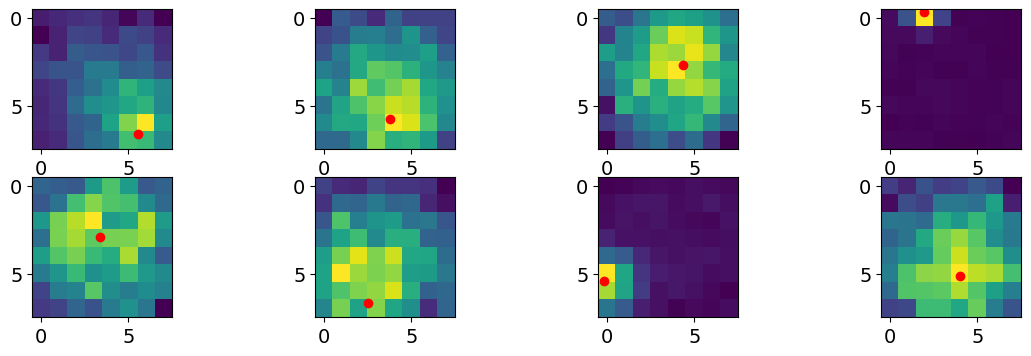

In [7]:
plot_images2(imgs, df1cs, (0,8), pixel_size = 6, grid_size=8)

In [8]:
energy = get_energy2(imgs)

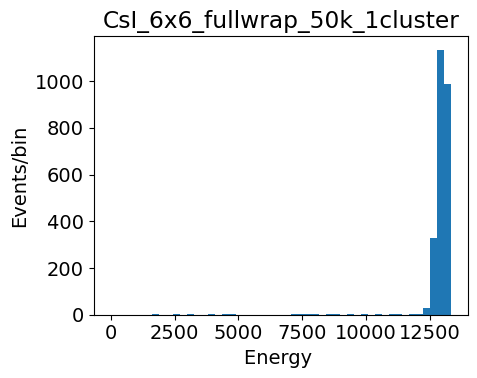

In [9]:
plot_energies2({"CsI_6x6_fullwrap_50k_1cluster":energy}, xmin=0, xmax=max(energy),num_bins = 50)

### Load data
- Use RDataset which stores (images, (x,y,z)).
- No normalization.
- No previous classification

In [11]:
first_file = 0  # initial file indx
last_file  = 100  # lasta file indx
batch_size = 200  # Batch size
train_fraction=0.7 
val_fraction=0.2

## 1c

In [12]:
dataset = RDataset(dir_root, first_file, last_file,type="1c", norm=False)  

Running rDataset with norm = False
Loading files in directory d1c with indexes: 0, 100
   event_id         e          x          y          z         t
0     10004  0.510118  18.645067  12.477487  29.249544  0.116340
1     10006  0.509274  13.566376   1.647984  21.156849  0.090734
2     10014  0.509922  -5.014233   5.060986  12.715019  0.062352
3     10018  0.508170 -22.957691  -9.322307  45.483715  0.171746
4     10024  0.508948  -3.514938  -0.639491  15.746504  0.074194
5     10026  0.508879  18.973616  -6.031100  16.421364  0.074508
6     10027  0.508849  11.437413 -22.155209  40.912632  0.157729
7     10028  0.509717   9.708068   3.101630  13.316263  0.064982
8     10029  0.509517   0.335767 -11.193620  21.898740  0.093051
9     10030  0.509092  16.716444  15.401320  25.922293  0.107143
image name = images_1.npy
image number = 1
number of images in file = 2605
number of labels in file = 2605
meta =>[1.00040000e+04 5.10118200e-01 1.86450670e+01 1.24774870e+01
 2.92495440e+01 1.16340

In [13]:
dataset[3]

(tensor([[[ 179.,  718., 2478.,  585.,  124.,  140.,  127.,  117.],
          [ 172.,  173.,  314.,  170.,  149.,  129.,  131.,  121.],
          [ 161.,  127.,  136.,  149.,  149.,  152.,  114.,  120.],
          [ 148.,  141.,  153.,  124.,  129.,  150.,  130.,  128.],
          [ 130.,  132.,  163.,  169.,  143.,  138.,  138.,  143.],
          [ 162.,  154.,  148.,  162.,  152.,  137.,  136.,  144.],
          [ 123.,  140.,  124.,  153.,  138.,  141.,  144.,  133.],
          [ 146.,  147.,  160.,  127.,  129.,  123.,  134.,  142.]]]),
 tensor([-22.9577,  -9.3223,  45.4837]))

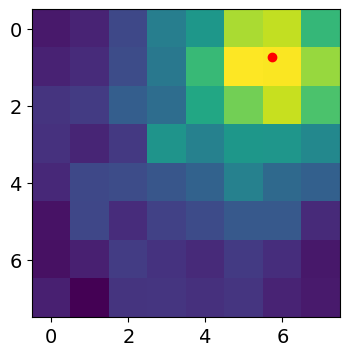

In [14]:
plot_dataset(dataset[15], pixel_size = 6, grid_size=8)

In [15]:
data_loader, train_loader, val_loader, test_loader = mono_data_loader(dataset, 
                                                                      batch_size=batch_size, 
                                                                      train_fraction=train_fraction, 
                                                                      val_fraction=val_fraction)

Loaded 259889 events
 train size = 181922
 val size = 51977
 test size = 25990
 train indices = range(0, 181922)
 val indices = range(181922, 233899)
 test indices = range(233899, 259889)
181922 training events (69.99988456610322%)
51977 validation events (19.999692176275257%)
25990 test events (10.000423257621524%)


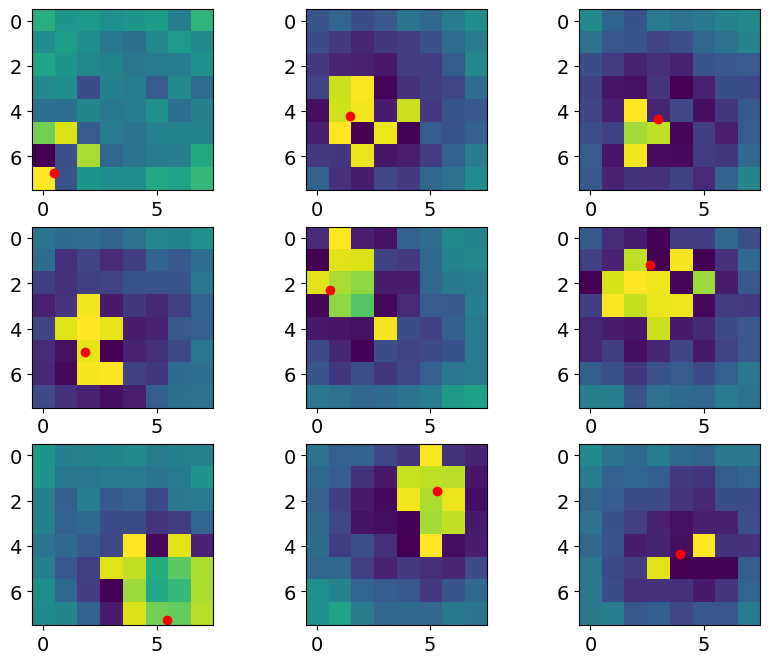

In [16]:
plot_images_and_positions(train_loader, start=0, figsize=(10, 8))

In [17]:
model = CNN_basic(chi=128, dropout=False, dropout_fraction=0.2, energy=False).to(device)

In [18]:
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

In [19]:
train_losses, val_losses = train_cnn(train_loader, val_loader, model, optimizer, device, criterion, 
                                     batch_size, epochs=20, iprnt=100)

Training with  ->182000 images
size of train loader  ->910 images
Evaluating with  ->52000 images
size of eval loader  ->260 images
Running for epochs ->20

EPOCH 0
input data shape =>torch.Size([200, 1, 8, 8])
(8,8,1) => (4,4,128) =>torch.Size([200, 128, 4, 4])
(4,4,128) => (2,2,256) =>torch.Size([200, 256, 2, 2])
(2,2,256) => (1,1,512) =>torch.Size([200, 512, 1, 1])
(1,1,512) => (1,1,3) =>torch.Size([200, 512])
torch.Size([200, 3])
--- EPOCH 0 AVG TRAIN LOSS: 12.05040983577351
--- EPOCH 0 AVG VAL LOSS: 8.48158893585205

EPOCH 1
--- EPOCH 1 AVG TRAIN LOSS: 7.904173432863676
--- EPOCH 1 AVG VAL LOSS: 7.543411592336802

EPOCH 2
--- EPOCH 2 AVG TRAIN LOSS: 7.267431252867311
--- EPOCH 2 AVG VAL LOSS: 7.831297867114728

EPOCH 3
--- EPOCH 3 AVG TRAIN LOSS: 6.852832459879446
--- EPOCH 3 AVG VAL LOSS: 6.989485872708834

EPOCH 4
--- EPOCH 4 AVG TRAIN LOSS: 6.5814680576324465
--- EPOCH 4 AVG VAL LOSS: 6.550189584952134

EPOCH 5
--- EPOCH 5 AVG TRAIN LOSS: 6.4092826890421435
--- EPOCH 5 AVG VAL 

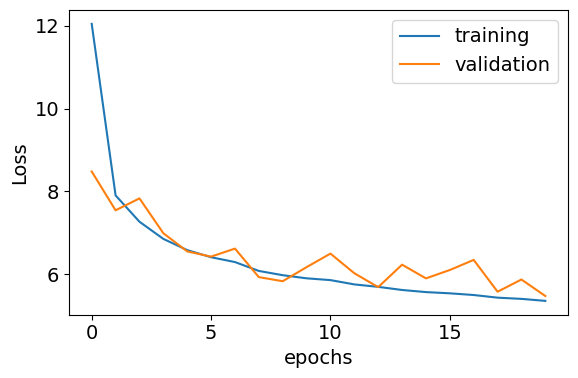

In [20]:
plot_loss(20, train_losses, val_losses,figsize=(6, 4))

In [21]:
tdeltas = evaluate_cnn(test_loader, model, device)

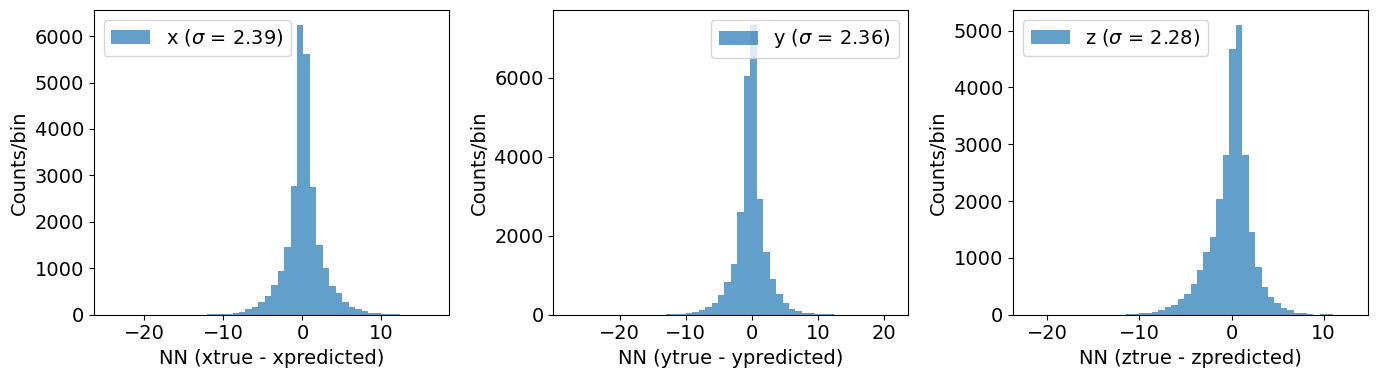

In [22]:
plotxyz(tdeltas, nbins=50)

In [23]:
f2gz, f2gx, f2gy = fit_tdeltas(tdeltas, bins=100)

2g fit: mu1 = 0.58, sigma = 0.66, n1  =0.64
2g fit: mu2 = -0.21, sigma = 2.37, n1  =0.36
weighted error: = 1.28
2g fit: mu1 = 0.07, sigma = 0.58, n1  =0.70
2g fit: mu2 = 0.21, sigma = 2.40, n1  =0.30
weighted error: = 1.13
2g fit: mu1 = -0.13, sigma = 0.59, n1  =0.69
2g fit: mu2 = -0.15, sigma = 2.34, n1  =0.31
weighted error: = 1.14


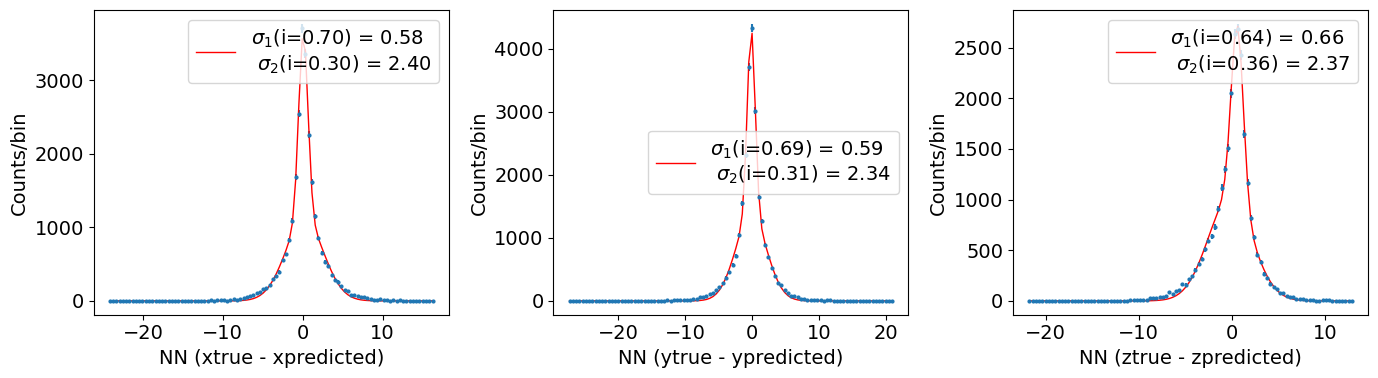

In [24]:
plotfxyz(f2gx, f2gy, f2gz, figsize=(14, 4))

## 2c

In [25]:
img_names, csv_name = get_file_names_format1(d2c)
df2c = pd.read_csv(csv_name[0])
df2c.head(10)

,event_id,e1,x1,y1,z1,t1,e2,x2,y2,z2,t2,etot
0,10001,0.391388,-5.125206,-7.548854,28.827255,0.137937,0.116762,-2.954058,-18.557474,22.369658,0.094753,0.508150
1,10003,0.330298,4.990295,0.311470,16.939790,0.091601,0.179934,11.767439,1.126573,13.503364,0.066109,0.510232
2,10009,0.322141,9.770208,10.759822,43.035156,0.164733,0.186507,12.210072,15.519191,37.142850,0.191277,0.508648
3,10010,0.156714,-13.614876,9.518246,20.837648,0.179916,0.033954,-2.227270,9.143230,12.844476,0.064596,0.507616
4,10013,0.265549,6.276037,13.364479,40.609715,0.156441,0.244618,21.409986,-10.269456,37.568260,0.250601,0.510166
5,10017,0.178680,10.950835,11.677908,17.862885,0.091082,0.329565,13.083003,7.918981,15.518206,0.072993,0.508245
6,10019,0.130845,3.697574,-9.119902,20.059360,0.088333,0.378074,4.120632,-2.767935,25.876673,0.117098,0.508920
7,10020,0.159400,11.349981,-20.220173,40.496056,0.169091,0.073342,15.039212,-22.794619,38.588585,0.152791,0.507276
8,10021,0.199376,17.825558,9.695036,39.495113,0.172827,0.310208,17.672928,13.185935,41.431313,0.159502,0.509583
9,10022,0.227905,-2.110336,3.168093,16.415188,0.131357,0.281414,1.825020,19.210318,16.948578,0.076230,0.509320


In [26]:
imgs, imgf_path, imgf_name, imfn = get_image_file_data(img_names,img_file_index=0)
print(f"image file path = {imgf_path}")
print(f"image file name = {imgf_name}")
print(f"image file number = {imfn}")
print(f"number of images in file = {len(imgs)}")


image file path = /home/investigator/Data/monolithic_csi/CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_vox_xy_6_z_12/df2c/images_1.npy
image file name = images_1.npy
image file number = 1
number of images in file = 2478


In [27]:
df2cs = get_img_file_metadata(df2c, imfn)  # This are the events corresponding to the images
print(f"number of labels in file = {len(df2cs)}")

number of labels in file = 2478


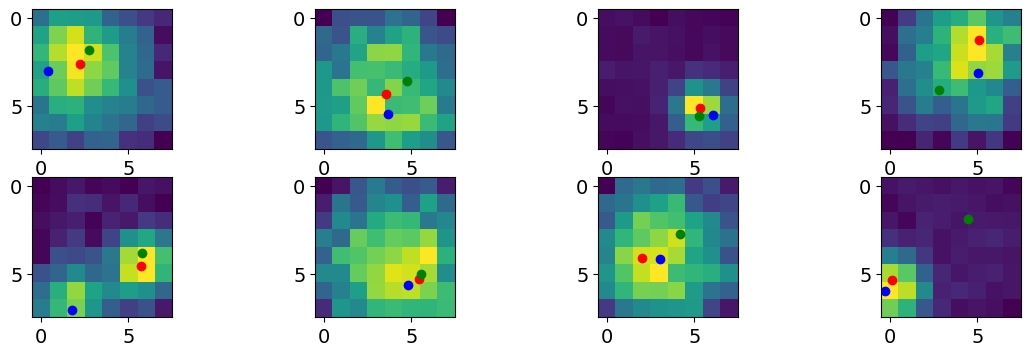

In [28]:
plot_images2c(imgs, df2cs, (0,8), pixel_size = 6, grid_size=8)

In [29]:
dataset = RDataset(dir_root, first_file, last_file,type="2c", norm=False) 

Running rDataset with norm = False
Loading files in directory d2c with indexes: 0, 100
   event_id        e1         x1         y1         z1        t1        e2  \
0     10001  0.391388  -5.125206  -7.548854  28.827255  0.137937  0.116762   
1     10003  0.330298   4.990295   0.311470  16.939790  0.091601  0.179934   
2     10009  0.322141   9.770208  10.759822  43.035156  0.164733  0.186507   
3     10010  0.156714 -13.614876   9.518246  20.837648  0.179916  0.033954   
4     10013  0.265549   6.276037  13.364479  40.609715  0.156441  0.244618   
5     10017  0.178680  10.950835  11.677908  17.862885  0.091082  0.329565   
6     10019  0.130845   3.697574  -9.119902  20.059360  0.088333  0.378074   
7     10020  0.159400  11.349981 -20.220173  40.496056  0.169091  0.073342   
8     10021  0.199376  17.825558   9.695036  39.495113  0.172827  0.310208   
9     10022  0.227905  -2.110336   3.168093  16.415188  0.131357  0.281414   

          x2         y2         z2        t2      etot

In [30]:
data_loader, train_loader, val_loader, test_loader = mono_data_loader(dataset, 
                                                                      batch_size=batch_size, 
                                                                      train_fraction=train_fraction, 
                                                                      val_fraction=val_fraction)

Loaded 252881 events
 train size = 177016
 val size = 50576
 test size = 25289
 train indices = range(0, 177016)
 val indices = range(177016, 227592)
 test indices = range(227592, 252881)
177016 training events (69.99972318995891%)
50576 validation events (19.999920911416833%)
25289 test events (10.000355898624255%)


In [31]:
model = CNN_basic(chi=128, dropout=False, dropout_fraction=0.2, energy=False).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

In [32]:
train_losses, val_losses = train_cnn(train_loader, val_loader, model, optimizer, device, criterion, 
                                     batch_size, epochs=20, iprnt=100)

Training with  ->177200 images
size of train loader  ->886 images
Evaluating with  ->50600 images
size of eval loader  ->253 images
Running for epochs ->20

EPOCH 0
input data shape =>torch.Size([200, 1, 8, 8])
(8,8,1) => (4,4,128) =>torch.Size([200, 128, 4, 4])
(4,4,128) => (2,2,256) =>torch.Size([200, 256, 2, 2])
(2,2,256) => (1,1,512) =>torch.Size([200, 512, 1, 1])
(1,1,512) => (1,1,3) =>torch.Size([200, 512])
torch.Size([200, 3])
--- EPOCH 0 AVG TRAIN LOSS: 25.950395945770747
--- EPOCH 0 AVG VAL LOSS: 24.908668608533535

EPOCH 1
--- EPOCH 1 AVG TRAIN LOSS: 21.46135906495036
--- EPOCH 1 AVG VAL LOSS: 21.27349101884563

EPOCH 2
--- EPOCH 2 AVG TRAIN LOSS: 20.547932764746534
--- EPOCH 2 AVG VAL LOSS: 19.832640983370453

EPOCH 3
--- EPOCH 3 AVG TRAIN LOSS: 19.952390822546207
--- EPOCH 3 AVG VAL LOSS: 20.124082275058914

EPOCH 4
--- EPOCH 4 AVG TRAIN LOSS: 19.622048255283193
--- EPOCH 4 AVG VAL LOSS: 19.814077445169684

EPOCH 5
--- EPOCH 5 AVG TRAIN LOSS: 19.348219743431557
--- EPOCH 5 

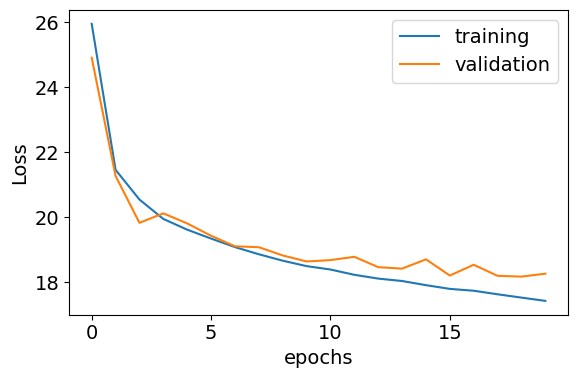

In [33]:
plot_loss(20, train_losses, val_losses,figsize=(6, 4))

In [34]:
tdeltas = evaluate_cnn(test_loader, model, device)

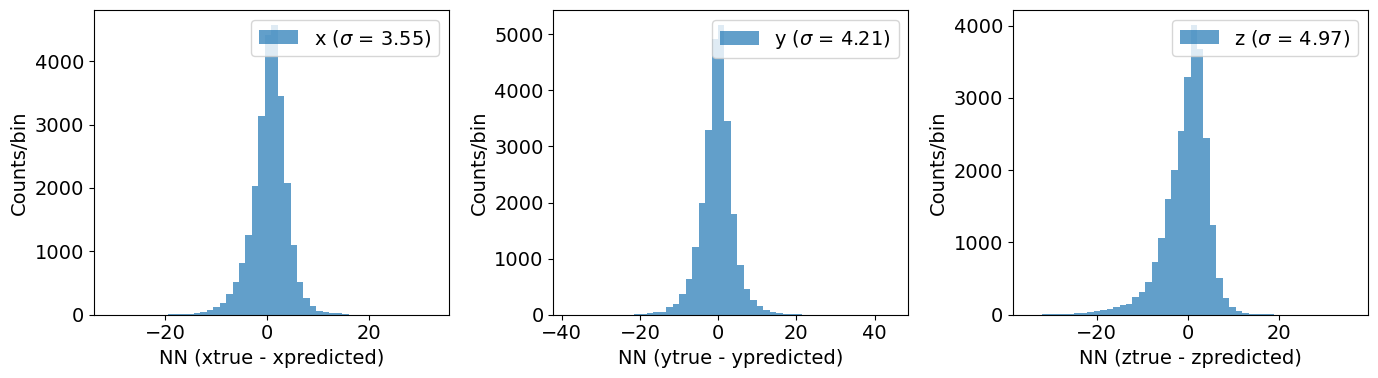

In [35]:
plotxyz(tdeltas, nbins=50)

In [36]:
f2gz, f2gx, f2gy = fit_tdeltas(tdeltas, bins=100)

2g fit: mu1 = 1.00, sigma = 2.71, n1  =0.72
2g fit: mu2 = -1.00, sigma = 5.91, n1  =0.28
weighted error: = 3.59
2g fit: mu1 = 1.00, sigma = 1.99, n1  =0.70
2g fit: mu2 = -0.02, sigma = 4.37, n1  =0.30
weighted error: = 2.70
2g fit: mu1 = -0.57, sigma = 4.34, n1  =0.46
2g fit: mu2 = 0.21, sigma = 1.84, n1  =0.54
weighted error: = 2.98


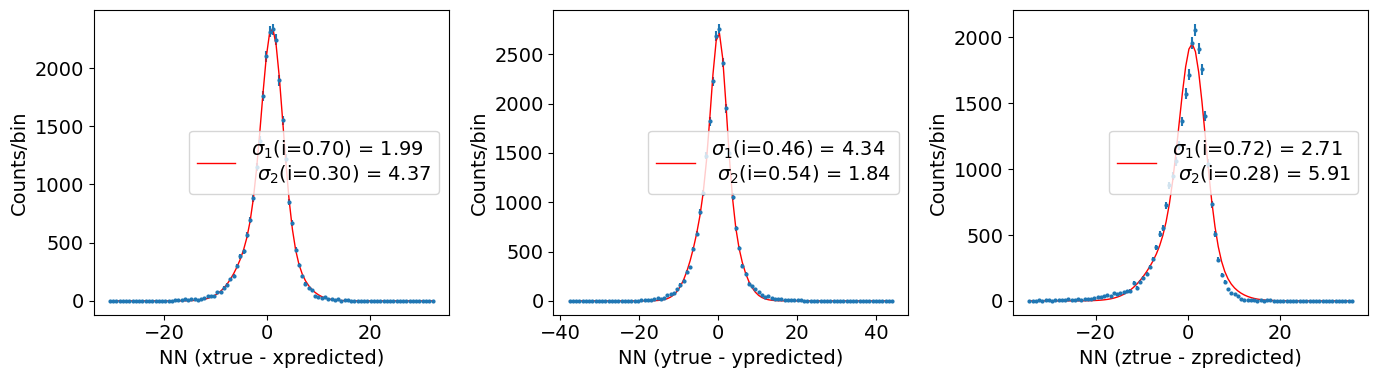

In [37]:
plotfxyz(f2gx, f2gy, f2gz, figsize=(14, 4))

## Resnet using 6 positions

In [38]:
dataset = R2Dataset(dir_root, first_file, last_file, type="2c", norm=False)  

Running rDataset with norm = False
Loading files in directory d2c with indexes: 0, 100
   event_id        e1         x1         y1         z1        t1        e2  \
0     10001  0.391388  -5.125206  -7.548854  28.827255  0.137937  0.116762   
1     10003  0.330298   4.990295   0.311470  16.939790  0.091601  0.179934   
2     10009  0.322141   9.770208  10.759822  43.035156  0.164733  0.186507   
3     10010  0.156714 -13.614876   9.518246  20.837648  0.179916  0.033954   
4     10013  0.265549   6.276037  13.364479  40.609715  0.156441  0.244618   
5     10017  0.178680  10.950835  11.677908  17.862885  0.091082  0.329565   
6     10019  0.130845   3.697574  -9.119902  20.059360  0.088333  0.378074   
7     10020  0.159400  11.349981 -20.220173  40.496056  0.169091  0.073342   
8     10021  0.199376  17.825558   9.695036  39.495113  0.172827  0.310208   
9     10022  0.227905  -2.110336   3.168093  16.415188  0.131357  0.281414   

          x2         y2         z2        t2      etot

In [39]:
data_loader, train_loader, val_loader, test_loader = mono_data_loader(dataset, 
                                                                      batch_size=batch_size, 
                                                                      train_fraction=train_fraction, 
                                                                      val_fraction=val_fraction)

Loaded 252881 events
 train size = 177016
 val size = 50576
 test size = 25289
 train indices = range(0, 177016)
 val indices = range(177016, 227592)
 test indices = range(227592, 252881)
177016 training events (69.99972318995891%)
50576 validation events (19.999920911416833%)
25289 test events (10.000355898624255%)


In [40]:
model2 = xResNet8(ResBlock, in_channels=1, out_channels=64, num_classes = 6, 
                 dropout_fraction=0.25, debug=True, dropout=True).to(device)

 ## make_layer 1: planes = 64,  blocks = 1, stride = 1
 ## make_layer: in_planes=64
 ## make_layer: downsample = None
 ## make_layer 2: planes = 128,  blocks = 1, stride = 2
 ## make_layer: in_planes=64
 ## make_layer: downsample = Sequential(
  (0): Conv2d(64, 128, kernel_size=(1, 1), stride=(2, 2))
  (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)
 ## make_layer 3: planes = 256,  blocks = 1, stride = 2
 ## make_layer: in_planes=128
 ## make_layer: downsample = Sequential(
  (0): Conv2d(128, 256, kernel_size=(1, 1), stride=(2, 2))
  (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)
 ## make_layer 4: planes = 512,  blocks = 1, stride = 2
 ## make_layer: in_planes=256
 ## make_layer: downsample = Sequential(
  (0): Conv2d(256, 512, kernel_size=(1, 1), stride=(2, 2))
  (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)


In [41]:
optimizer = optim.Adam(model2.parameters(), lr=0.001)
criterion = nn.MSELoss()

In [42]:
train_losses, val_losses = train_cnn(train_loader, val_loader, model2, optimizer, device, criterion, 
                                     batch_size, epochs=20, iprnt=100)

Training with  ->177200 images
size of train loader  ->886 images
Evaluating with  ->50600 images
size of eval loader  ->253 images
Running for epochs ->20

EPOCH 0
  ResNet8: input data shape =>torch.Size([200, 1, 8, 8])
  ResNet8: after conv1 =>torch.Size([200, 64, 8, 8])
  ResNet8: after layer0 =>torch.Size([200, 64, 8, 8])
  ResNet8: after layer1 =>torch.Size([200, 128, 4, 4])
  ResNet8: after layer2 =>torch.Size([200, 256, 2, 2])
  ResNet8: after layer3 =>torch.Size([200, 512, 1, 1])
  ResNet8: after avgpool =>torch.Size([200, 512, 1, 1])
  ResNet8: after flatten =>torch.Size([200, 512])
  ResNet8: after fc =>torch.Size([200, 6])
--- EPOCH 0 AVG TRAIN LOSS: 30.784806120207293
--- EPOCH 0 AVG VAL LOSS: 20.43295991467864

EPOCH 1
--- EPOCH 1 AVG TRAIN LOSS: 20.411948586156083
--- EPOCH 1 AVG VAL LOSS: 21.355973910908453

EPOCH 2
--- EPOCH 2 AVG TRAIN LOSS: 19.592355443984605
--- EPOCH 2 AVG VAL LOSS: 20.617496807113465

EPOCH 3
--- EPOCH 3 AVG TRAIN LOSS: 19.133600522379304
--- EPOC

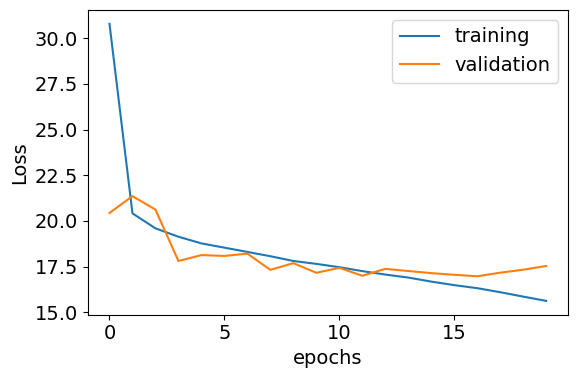

In [43]:
plot_loss(20, train_losses, val_losses,figsize=(6, 4))

In [44]:
tdeltas = evaluate_cnn(test_loader, model2, device)

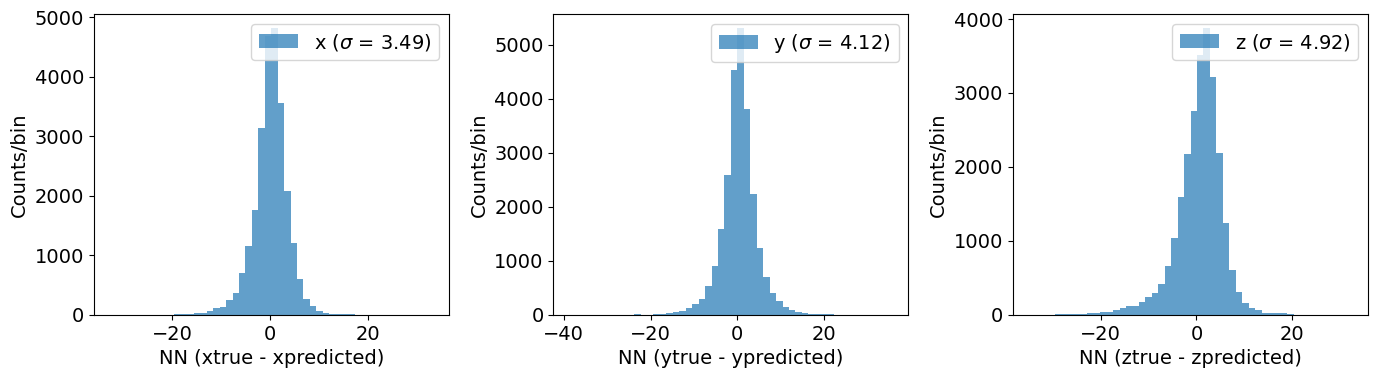

In [45]:
plotxyz(tdeltas, nbins=50)

In [46]:
f2gz, f2gx, f2gy = fit_tdeltas(tdeltas, bins=100)

2g fit: mu1 = -0.07, sigma = 10.01, n1  =0.06
2g fit: mu2 = 1.00, sigma = 3.33, n1  =0.94
weighted error: = 3.76
2g fit: mu1 = 0.48, sigma = 1.70, n1  =0.59
2g fit: mu2 = 0.17, sigma = 3.89, n1  =0.41
weighted error: = 2.61
2g fit: mu1 = 0.41, sigma = 4.21, n1  =0.42
2g fit: mu2 = 0.47, sigma = 1.61, n1  =0.58
weighted error: = 2.71


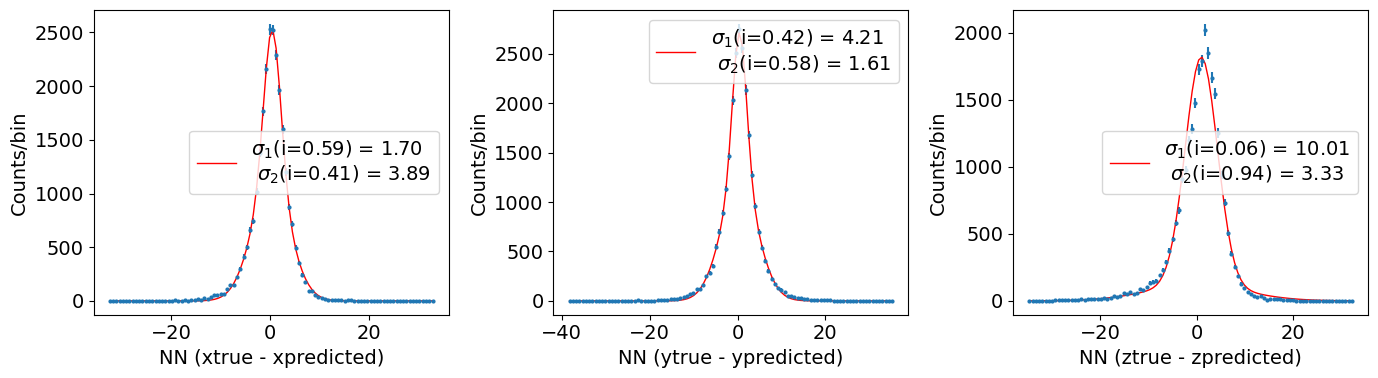

In [47]:
plotfxyz(f2gx, f2gy, f2gz, figsize=(14, 4))

## Summary:
- Resolution with 1c ~ 1.1 mm 2c ~ 2.5mm
- classification accuracy ~80% 1c, 50 % 2c
- Need classification.
- What is the optimal?

## 14 mm

In [76]:
data_dir = Path(os.environ['MONOLITH_DATA'])
dir_root = os.path.join(data_dir,"CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_2_vox_14mm")
d1c = os.path.join(dir_root,"df1c")
d2c = os.path.join(dir_root,"df2c")
dnc = os.path.join(dir_root,"dfnc")

img_names, csv_name = get_file_names_format1(d1c)

print(f"name of first image file = {img_names[0]}")
print(f"name of label file ={csv_name}")


name of first image file = /home/investigator/Data/monolithic_csi/CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_2_vox_14mm/df1c/images_1.npy
name of label file =['/home/investigator/Data/monolithic_csi/CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_2_vox_14mm/df1c/df1c_14mm.csv']


In [77]:
df1c = pd.read_csv(csv_name[0])
df1c.head(10)

,event_id,e,x,y,z,t
0,10006,0.509922,-11.797090,-18.706337,19.845798,0.128977
1,10013,0.508865,-5.694461,-15.383989,1.317396,0.067932
2,10014,0.510058,-12.474124,-23.824984,6.198423,0.081103
3,10016,0.510171,21.307316,19.975979,5.213755,0.080465
4,10017,0.509717,-19.122648,20.913584,35.491890,0.179873
5,10026,0.507920,11.565461,-7.917347,10.502496,0.097198
6,10027,0.509717,-16.532148,9.670679,33.228730,0.172357
7,10028,0.507915,2.573587,-15.676525,35.443943,0.179403
8,10031,0.510007,-2.871538,3.663483,28.352789,0.158213
9,10032,0.504709,9.817309,-13.075654,8.430389,0.090342


In [78]:
dataset = RDataset(dir_root, first_file, last_file,type="1c", norm=False)  

Running rDataset with norm = False
Loading files in directory d1c with indexes: 0, 100
   event_id         e          x          y          z         t
0     10006  0.509922 -11.797090 -18.706337  19.845798  0.128977
1     10013  0.508865  -5.694461 -15.383989   1.317396  0.067932
2     10014  0.510058 -12.474124 -23.824984   6.198423  0.081103
3     10016  0.510171  21.307316  19.975979   5.213755  0.080465
4     10017  0.509717 -19.122648  20.913584  35.491890  0.179873
5     10026  0.507920  11.565461  -7.917347  10.502496  0.097198
6     10027  0.509717 -16.532148   9.670679  33.228730  0.172357
7     10028  0.507915   2.573587 -15.676525  35.443943  0.179403
8     10031  0.510007  -2.871538   3.663483  28.352789  0.158213
9     10032  0.504709   9.817309 -13.075654   8.430389  0.090342
image name = images_1.npy
image number = 1
number of images in file = 3194
number of labels in file = 3194
meta =>[ 1.0006000e+04  5.0992167e-01 -1.1797090e+01 -1.8706337e+01
  1.9845798e+01  1.2897

In [79]:
data_loader, train_loader, val_loader, test_loader = mono_data_loader(dataset, 
                                                                      batch_size=batch_size, 
                                                                      train_fraction=train_fraction, 
                                                                      val_fraction=val_fraction)

Loaded 317674 events
 train size = 222371
 val size = 63534
 test size = 31769
 train indices = range(0, 222371)
 val indices = range(222371, 285905)
 test indices = range(285905, 317674)
222371 training events (69.9997481695071%)
63534 validation events (19.999748169507104%)
31769 test events (10.00050366098579%)


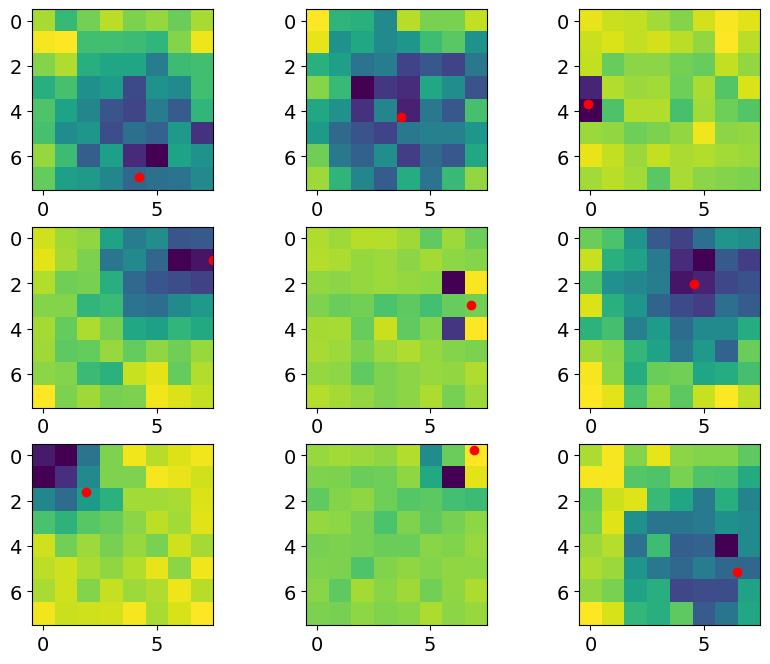

In [80]:
plot_images_and_positions(train_loader, start=0, figsize=(10, 8))

In [81]:
model = CNN_basic(chi=128, dropout=False, dropout_fraction=0.2, energy=False).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()


In [82]:
train_losses, val_losses = train_cnn(train_loader, val_loader, model, optimizer, device, criterion, 
                                     batch_size, epochs=20, iprnt=100)

Training with  ->222400 images
size of train loader  ->1112 images
Evaluating with  ->63600 images
size of eval loader  ->318 images
Running for epochs ->20

EPOCH 0
input data shape =>torch.Size([200, 1, 8, 8])
(8,8,1) => (4,4,128) =>torch.Size([200, 128, 4, 4])
(4,4,128) => (2,2,256) =>torch.Size([200, 256, 2, 2])
(2,2,256) => (1,1,512) =>torch.Size([200, 512, 1, 1])
(1,1,512) => (1,1,3) =>torch.Size([200, 512])
torch.Size([200, 3])
--- EPOCH 0 AVG TRAIN LOSS: 10.489855211415737
--- EPOCH 0 AVG VAL LOSS: 8.837225771550113

EPOCH 1
--- EPOCH 1 AVG TRAIN LOSS: 8.02488265878005
--- EPOCH 1 AVG VAL LOSS: 7.482915630880392

EPOCH 2
--- EPOCH 2 AVG TRAIN LOSS: 7.531244693900184
--- EPOCH 2 AVG VAL LOSS: 7.307471162867996

EPOCH 3
--- EPOCH 3 AVG TRAIN LOSS: 7.25244761971261
--- EPOCH 3 AVG VAL LOSS: 7.26857870929646

EPOCH 4
--- EPOCH 4 AVG TRAIN LOSS: 7.012966442451202
--- EPOCH 4 AVG VAL LOSS: 6.904762537974231

EPOCH 5
--- EPOCH 5 AVG TRAIN LOSS: 6.837700206169979
--- EPOCH 5 AVG VAL LO

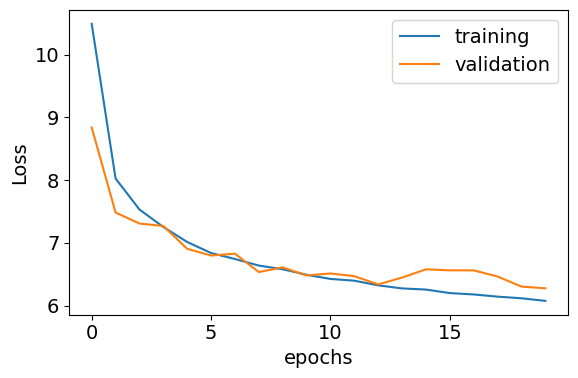

In [83]:
plot_loss(20, train_losses, val_losses,figsize=(6, 4))

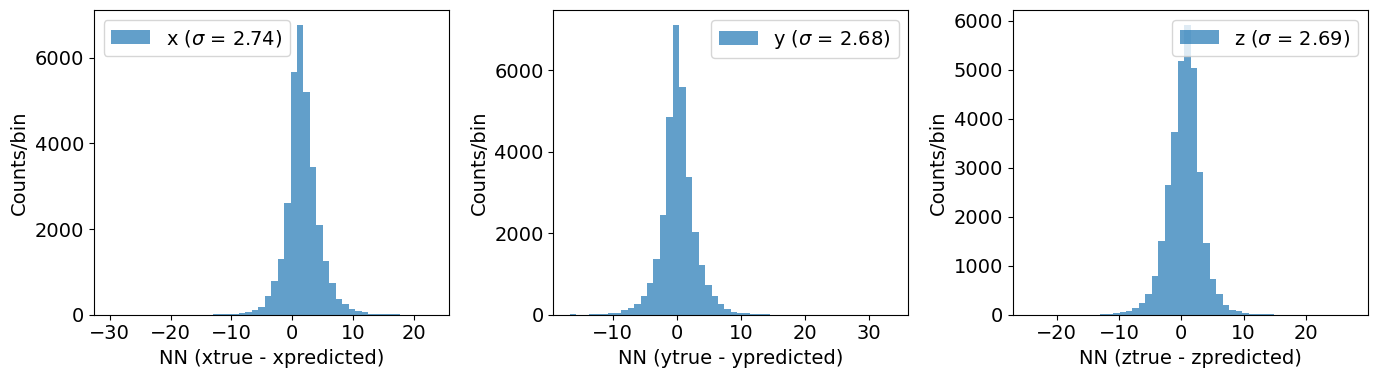

In [85]:
tdeltas = evaluate_cnn(test_loader, model2, device)
plotxyz(tdeltas, nbins=50)

2g fit: mu1 = 0.32, sigma = 2.76, n1  =0.55
2g fit: mu2 = 1.00, sigma = 1.34, n1  =0.45
weighted error: = 2.13
2g fit: mu1 = 1.00, sigma = 1.03, n1  =0.55
2g fit: mu2 = 1.00, sigma = 2.92, n1  =0.45
weighted error: = 1.89
2g fit: mu1 = -0.02, sigma = 0.98, n1  =0.59
2g fit: mu2 = 0.37, sigma = 2.81, n1  =0.41
weighted error: = 1.72


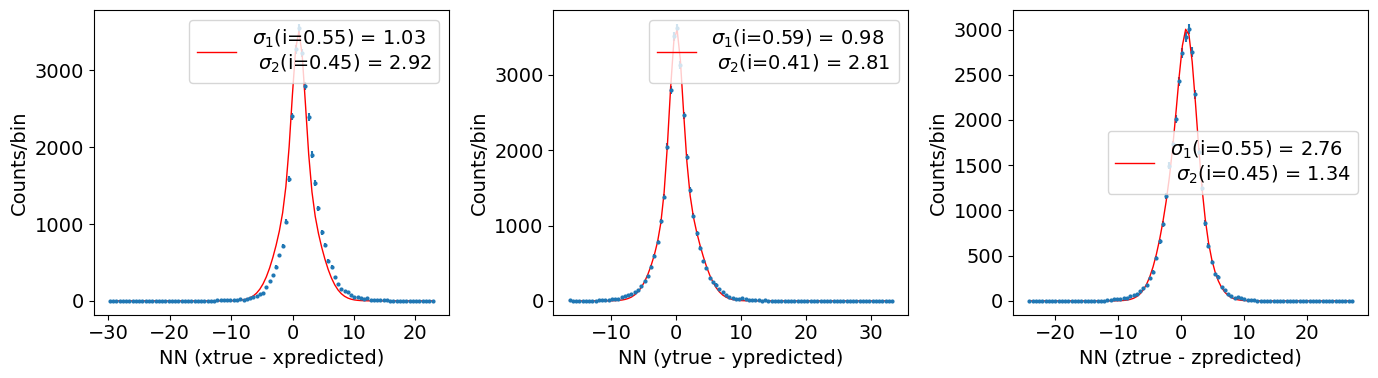

In [86]:
f2gz, f2gx, f2gy = fit_tdeltas(tdeltas, bins=100)
plotfxyz(f2gx, f2gy, f2gz, figsize=(14, 4))

## 9 mm

In [104]:
data_dir = Path(os.environ['MONOLITH_DATA'])
dir_root = os.path.join(data_dir,"CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_2_vox_9mm")
d1c = os.path.join(dir_root,"df1c")
d2c = os.path.join(dir_root,"df2c")
dnc = os.path.join(dir_root,"dfnc")

img_names, csv_name = get_file_names_format1(d1c)

print(f"name of first image file = {img_names[0]}")
print(f"name of label file ={csv_name}")

name of first image file = /home/investigator/Data/monolithic_csi/CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_2_vox_9mm/df1c/images_1.npy
name of label file =['/home/investigator/Data/monolithic_csi/CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_2_vox_9mm/df1c/df1c_9mm.csv']


In [105]:
dataset = RDataset(dir_root, first_file, last_file,type="1c", norm=False)  
data_loader, train_loader, val_loader, test_loader = mono_data_loader(dataset, 
                                                                      batch_size=batch_size, 
                                                                      train_fraction=train_fraction, 
                                                                      val_fraction=val_fraction)

Running rDataset with norm = False
Loading files in directory d1c with indexes: 0, 100
   event_id         e          x          y          z         t
0     10006  0.509922 -11.797090 -18.706337  19.845798  0.128977
1     10013  0.508865  -5.694461 -15.383989   1.317396  0.067932
2     10014  0.510058 -12.474124 -23.824984   6.198423  0.081103
3     10016  0.510171  21.307316  19.975979   5.213755  0.080465
4     10017  0.509717 -19.122648  20.913584  35.491890  0.179873
5     10026  0.507920  11.565461  -7.917347  10.502496  0.097198
6     10027  0.509717 -16.532148   9.670679  33.228730  0.172357
7     10028  0.507915   2.573587 -15.676525  35.443943  0.179403
8     10031  0.510007  -2.871538   3.663483  28.352789  0.158213
9     10033  0.509915  21.300068 -14.392266  15.292956  0.114090
image name = images_1.npy
image number = 1
number of images in file = 2745
number of labels in file = 2745
meta =>[ 1.0006000e+04  5.0992167e-01 -1.1797090e+01 -1.8706337e+01
  1.9845798e+01  1.2897

In [108]:
model = CNN_basic(chi=128, dropout=True, dropout_fraction=0.2, energy=False).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

In [109]:
train_losses, val_losses = train_cnn(train_loader, val_loader, model, optimizer, device, criterion, 
                                     batch_size, epochs=20, iprnt=100)

Training with  ->192400 images
size of train loader  ->1924 images
Evaluating with  ->55000 images
size of eval loader  ->550 images
Running for epochs ->20

EPOCH 0
input data shape =>torch.Size([100, 1, 8, 8])
(8,8,1) => (4,4,128) =>torch.Size([100, 128, 4, 4])
(4,4,128) => (2,2,256) =>torch.Size([100, 256, 2, 2])
(2,2,256) => (1,1,512) =>torch.Size([100, 512, 1, 1])
(1,1,512) => (1,1,3) =>torch.Size([100, 512])
torch.Size([100, 3])
--- EPOCH 0 AVG TRAIN LOSS: 11.247610000215795
--- EPOCH 0 AVG VAL LOSS: 9.76569048014554

EPOCH 1
--- EPOCH 1 AVG TRAIN LOSS: 8.440910453855867
--- EPOCH 1 AVG VAL LOSS: 7.72171255198392

EPOCH 2
--- EPOCH 2 AVG TRAIN LOSS: 7.852052372607273
--- EPOCH 2 AVG VAL LOSS: 6.87183667789806

EPOCH 3
--- EPOCH 3 AVG TRAIN LOSS: 7.5479741914356575
--- EPOCH 3 AVG VAL LOSS: 6.913475654775446

EPOCH 4
--- EPOCH 4 AVG TRAIN LOSS: 7.324929811106898
--- EPOCH 4 AVG VAL LOSS: 6.539882512526079

EPOCH 5
--- EPOCH 5 AVG TRAIN LOSS: 7.121560306905956
--- EPOCH 5 AVG VAL L

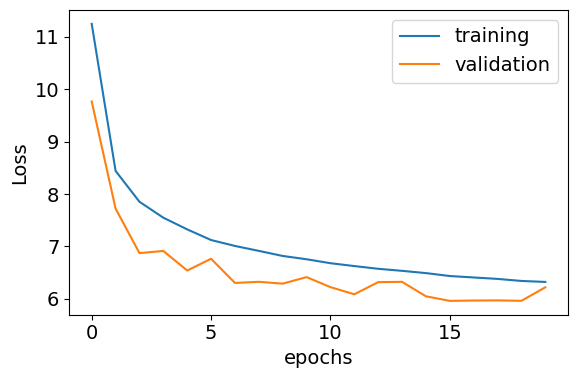

In [110]:
plot_loss(20, train_losses, val_losses,figsize=(6, 4))

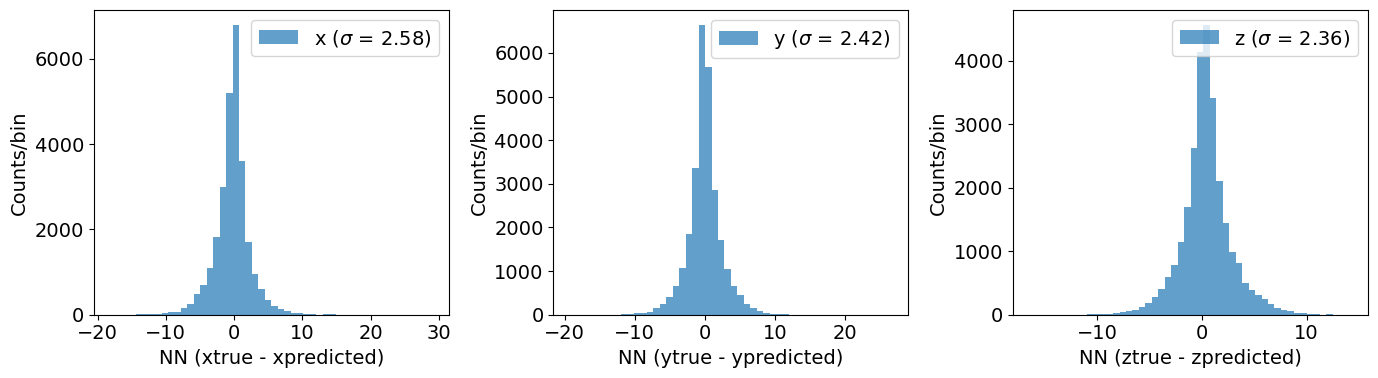

In [111]:
tdeltas = evaluate_cnn(test_loader, model, device)
plotxyz(tdeltas, nbins=50)

2g fit: mu1 = 0.40, sigma = 2.64, n1  =0.35
2g fit: mu2 = 0.28, sigma = 0.80, n1  =0.65
weighted error: = 1.44
2g fit: mu1 = 0.06, sigma = 0.73, n1  =0.62
2g fit: mu2 = -0.41, sigma = 2.50, n1  =0.38
weighted error: = 1.40
2g fit: mu1 = -0.12, sigma = 0.67, n1  =0.63
2g fit: mu2 = -0.02, sigma = 2.48, n1  =0.37
weighted error: = 1.33


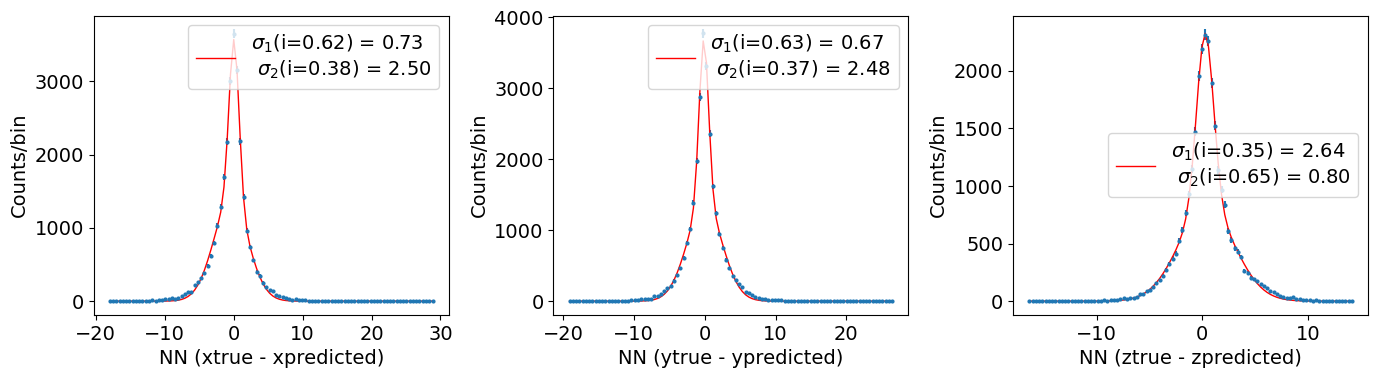

In [112]:
f2gz, f2gx, f2gy = fit_tdeltas(tdeltas, bins=100)
plotfxyz(f2gx, f2gy, f2gz, figsize=(14, 4))

## Vox at 12 mm (CsI)

In [94]:
data_dir = Path(os.environ['MONOLITH_DATA'])
dir_root = os.path.join(data_dir,"CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_vox_12mm")
d1c = os.path.join(dir_root,"df1c")
d2c = os.path.join(dir_root,"df2c")
dnc = os.path.join(dir_root,"dfnc")

In [95]:
first_file = 0  # initial file indx
last_file  = 100  # lasta file indx
batch_size = 100  # Batch size
train_fraction=0.7 
val_fraction=0.2

In [96]:
dataset = RDataset(dir_root, first_file, last_file,type="1c", norm=False)  

Running rDataset with norm = False
Loading files in directory d1c with indexes: 0, 100
   event_id         e          x          y          z         t
0     10004  0.510118  18.645067  12.477487  29.249544  0.116340
1     10006  0.509274  13.566376   1.647984  21.156849  0.090734
2     10014  0.509922  -5.014233   5.060986  12.715019  0.062352
3     10018  0.508170 -22.957691  -9.322307  45.483715  0.171746
4     10024  0.508948  -3.514938  -0.639491  15.746504  0.074194
5     10026  0.508879  18.973616  -6.031100  16.421364  0.074508
6     10027  0.508849  11.437413 -22.155209  40.912632  0.157729
7     10028  0.509717   9.708068   3.101630  13.316263  0.064982
8     10029  0.509517   0.335767 -11.193620  21.898740  0.093051
9     10030  0.509092  16.716444  15.401320  25.922293  0.107143
image name = images_1.npy
image number = 1
number of images in file = 3032
number of labels in file = 3032
meta =>[1.00040000e+04 5.10118200e-01 1.86450670e+01 1.24774870e+01
 2.92495440e+01 1.16340

In [98]:
model = CNN_basic(chi=128, dropout=True, dropout_fraction=0.2, energy=False).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

In [99]:
train_losses, val_losses = train_cnn(train_loader, val_loader, model, optimizer, device, criterion, 
                                     batch_size, epochs=20, iprnt=100)

Training with  ->96200 images
size of train loader  ->962 images
Evaluating with  ->27500 images
size of eval loader  ->275 images
Running for epochs ->20

EPOCH 0
input data shape =>torch.Size([200, 1, 8, 8])
(8,8,1) => (4,4,128) =>torch.Size([200, 128, 4, 4])
(4,4,128) => (2,2,256) =>torch.Size([200, 256, 2, 2])
(2,2,256) => (1,1,512) =>torch.Size([200, 512, 1, 1])
(1,1,512) => (1,1,3) =>torch.Size([200, 512])
torch.Size([200, 3])
--- EPOCH 0 AVG TRAIN LOSS: 11.479629703965852
--- EPOCH 0 AVG VAL LOSS: 8.627099709944291

EPOCH 1
--- EPOCH 1 AVG TRAIN LOSS: 8.605128600047184
--- EPOCH 1 AVG VAL LOSS: 7.168205171064897

EPOCH 2
--- EPOCH 2 AVG TRAIN LOSS: 8.017552521521237
--- EPOCH 2 AVG VAL LOSS: 7.376226848255504

EPOCH 3
--- EPOCH 3 AVG TRAIN LOSS: 7.657393225513228
--- EPOCH 3 AVG VAL LOSS: 6.917264624508944

EPOCH 4
--- EPOCH 4 AVG TRAIN LOSS: 7.423727192155041
--- EPOCH 4 AVG VAL LOSS: 7.076309821388938

EPOCH 5
--- EPOCH 5 AVG TRAIN LOSS: 7.2983185099960615
--- EPOCH 5 AVG VAL 

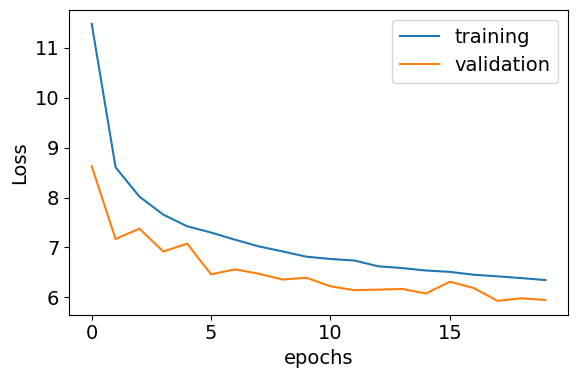

In [100]:
plot_loss(20, train_losses, val_losses,figsize=(6, 4))

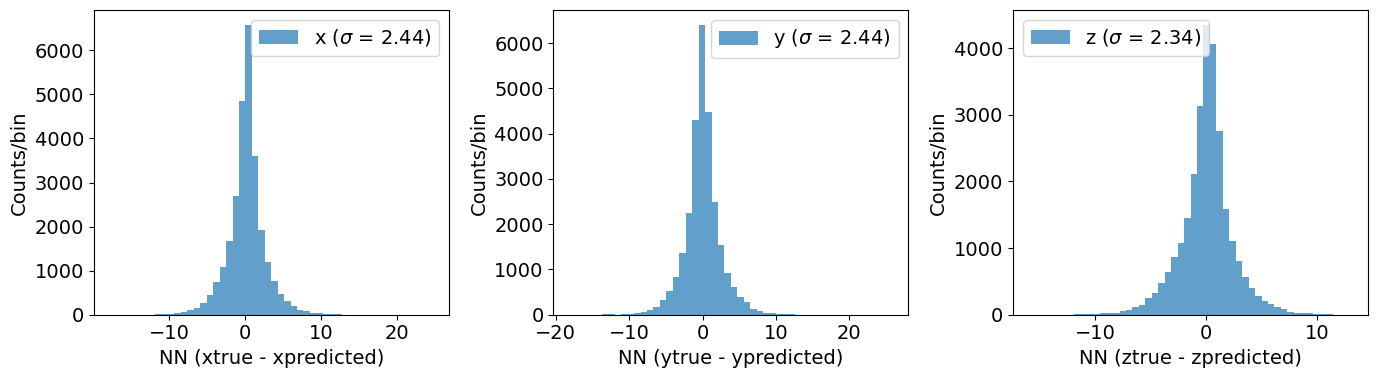

In [102]:
tdeltas = evaluate_cnn(test_loader, model, device)
plotxyz(tdeltas, nbins=50)

2g fit: mu1 = 0.27, sigma = 0.75, n1  =0.64
2g fit: mu2 = -0.07, sigma = 2.56, n1  =0.36
weighted error: = 1.40
2g fit: mu1 = 0.33, sigma = 0.65, n1  =0.63
2g fit: mu2 = 0.11, sigma = 2.47, n1  =0.37
weighted error: = 1.33
2g fit: mu1 = -0.09, sigma = 0.76, n1  =0.62
2g fit: mu2 = 0.05, sigma = 2.57, n1  =0.38
weighted error: = 1.44


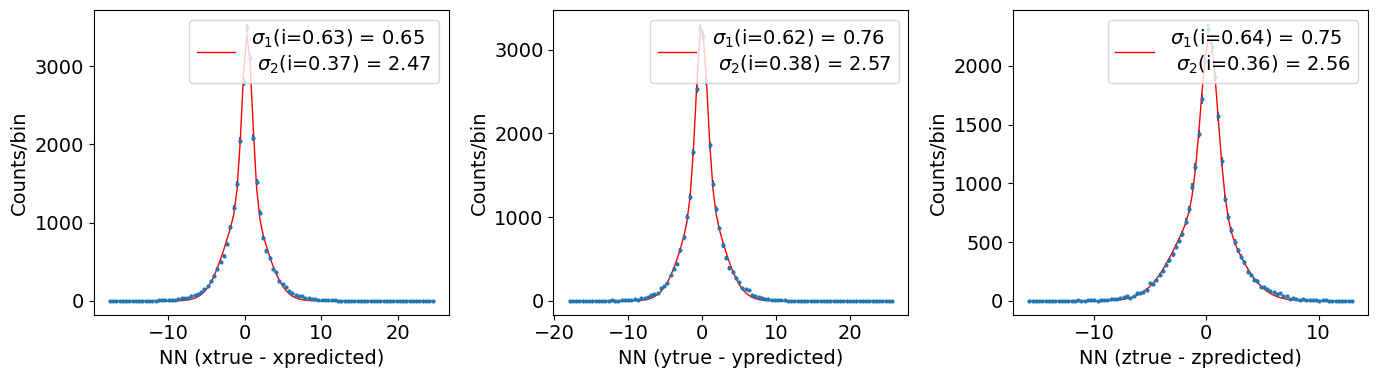

In [103]:
f2gz, f2gx, f2gy = fit_tdeltas(tdeltas, bins=100)
plotfxyz(f2gx, f2gy, f2gz, figsize=(14, 4))